In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


<h1>Background</h1>
Twitter has become an important communication channel. The smartphones enable people to tweet an emergency in real time. If we can distinguish the real disaster from the disaster words, the system can be utilized to become an emergency alarm system.
The basic flow of the notebook is load data, EDA, build model, fine-tuning the model, get test dataset result.


In [66]:
import random
import matplotlib.pyplot as plt
import re
import string

import seaborn as sns

import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense

from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



In [67]:
#Load data
TRAIN_PATH = "/kaggle/input/nlp-getting-started/train.csv"
TEST_PATH  = "/kaggle/input/nlp-getting-started/test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (7613, 5)
Test shape: (3263, 4)


In [68]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [69]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


<h1>Exploratory Data Analysis (EDA) </h1>
We can visualize the tweets' length. Median length of a tweet is 107, with a minimum of 7 and a maximum of 157. Then, we did word learning and converted it to vectors.


target
0    4342
1    3271
Name: count, dtype: int64
Text length: min, median, max are 7 107.0 157


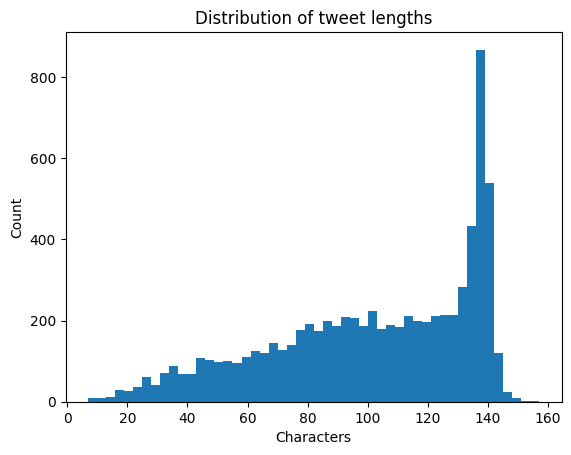

In [72]:
print(train_df['target'].value_counts())
train_df['text_len'] = train_df['text'].astype(str).apply(len)
print("Text length: min, median, max are", train_df['text_len'].min(), train_df['text_len'].median(), train_df['text_len'].max())

# Plot text length histogram
plt.hist(train_df['text_len'], bins=50)
plt.title("Distribution of tweet lengths")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()


In [19]:
#print(train_df['target'].value_counts(normalize=True))

<h2>Clean Data</h2>
Before training the model, it is important to clean the data to improve performance.

I removed new line characters (\n), URLs, mentions (@username), and extra whitespace, and converted all letters to lowercase.

In [73]:
# Data cleaning
def clean_text(text):
    text = str(text)
    text = text.replace('\n', ' ')
    # remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # remove mentions
    text = re.sub(r'@\w+', '', text)
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # lower
    text = text.strip().lower()
    return text

train_df['clean_text'] = train_df['text'].astype(str).map(clean_text)
test_df['clean_text']  = test_df['text'].astype(str).map(clean_text)
train_df[['text', 'clean_text']].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this #earthquake m...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada
2,All residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby #alaska as ...


<h2>Text to Token</h2>
I preprocess the text into tokens so that the model can understand it. 
I use Word2Vec because, unlike GloVe, it does not require extra loading and can be trained quickly on our dataset. TF-IDF cannot be used with LSTM, as it destroys the word order, while LSTM relies on the sequence of words. Word2Vec preserves the original word order, making it suitable for sequential models like LSTM and BiLSTM.

In [74]:
MAX_NB_WORDS = 20000
MAX_SEQ_LEN = 60
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_df["clean_text"])

X = tokenizer.texts_to_sequences(train_df["clean_text"])
X = pad_sequences(X, maxlen=MAX_SEQ_LEN)

y = train_df["target"].values

X_test = tokenizer.texts_to_sequences(test_df["clean_text"])
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LEN)

In [75]:
sentences = [text.split() for text in train_df["clean_text"]]

w2v_model = Word2Vec(
    sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4
)

vocab_size = min(MAX_NB_WORDS, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


<h1>Model Architecture</h1>

<h2>LSTM model</h2>

I start with a basic LSTM model as a baseline. Evaluation using F1 since this is the performance metric that the competition is using.

LSTM (Long Short-Term Memory) networks are a type of RNN. In text data, the order of words is important for understanding context and meaning. LSTM can remember information from previous words in a sequence, making it suitable for tasks like disaster tweet classification, where certain keywords or patterns may indicate relevance.

Starting with a simple LSTM provides a reference point to compare more complex architectures, such as BiLSTM or models with additional dense layers and learning rates.

In [76]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)
print(X_train.shape)
print(X_val.shape)

(6851, 60)
(762, 60)


In [77]:
def tune_threshold(model, X_val, y_val, plot=False):
    y_prob = model.predict(X_val).ravel()
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []

    best_f1 = 0
    best_t = 0.5

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(thresholds, f1_scores)
        plt.axvline(best_t, color='r', linestyle='--', label=f"Best t={best_t:.2f}")
        plt.xlabel("Threshold")
        plt.ylabel("F1 Score")
        plt.title("Threshold Tuning Curve")
        plt.legend()
        plt.show()

    return best_t, best_f1

In [78]:
# Set evaluation method to F1
def evaluate_model(name, model, X_val, y_val, plot=True):
    y_prob = model.predict(X_val).ravel()
    
    # Default threshold = 0.5
    y_pred_default = (y_prob >= 0.5).astype(int)
    f1_default = f1_score(y_val, y_pred_default)

    # Tuned threshold
    best_t, best_f1 = tune_threshold(model, X_val, y_val, plot=plot)

    print(f"\n===== {name} Evaluation =====")
    print(f"F1 @ threshold=0.5: {f1_default:.4f}")
    print(f"Best threshold: {best_t:.2f}")
    print(f"Best F1: {best_f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, (y_prob >= best_t).astype(int))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix (t={best_t:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return best_t, best_f1

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.6916 - val_loss: 0.6818
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.6799 - val_loss: 0.6833
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.6697 - val_loss: 0.6507
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


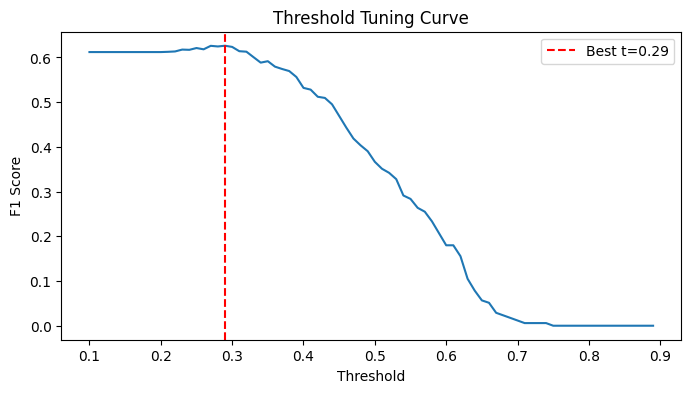


===== LSTM Evaluation =====
F1 @ threshold=0.5: 0.3665
Best threshold: 0.29
Best F1: 0.6262


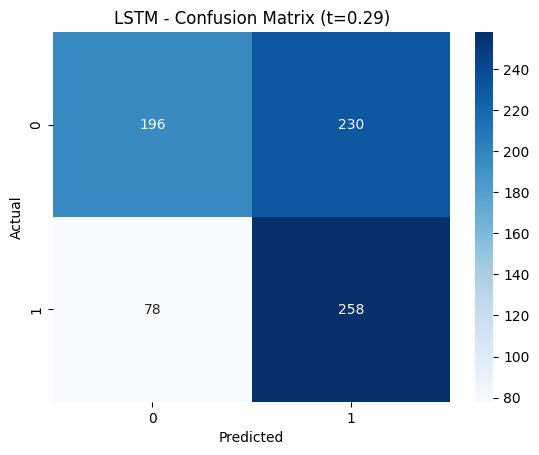

In [85]:
# Basic LSTM model
model_lstm = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=False),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(
    loss="binary_crossentropy",
    optimizer="adam"
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_lstm, best_f1_lstm = evaluate_model("LSTM", model_lstm, X_val, y_val)

<h1>Optimization</h1>
First round result of LSTM without optimization is 0.6262.

Next, I experimented with a more advanced architecture, the Bidirectional LSTM (BiLSTM). This model captures context from both past and future words in a sequence, but its initial score was 0.6168, slightly lower than the baseline LSTM.

To improve performance, I then fine-tuned various hyperparameters, including:

Smaller LSTM units

Adding dense layers after the LSTM/BiLSTM to better transform features

Adjusting the learning rate

Changing dropout rates

Setting the embedding layer as trainable

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.6895 - val_loss: 0.7011
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.6837 - val_loss: 0.6965
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.6663 - val_loss: 0.6851
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


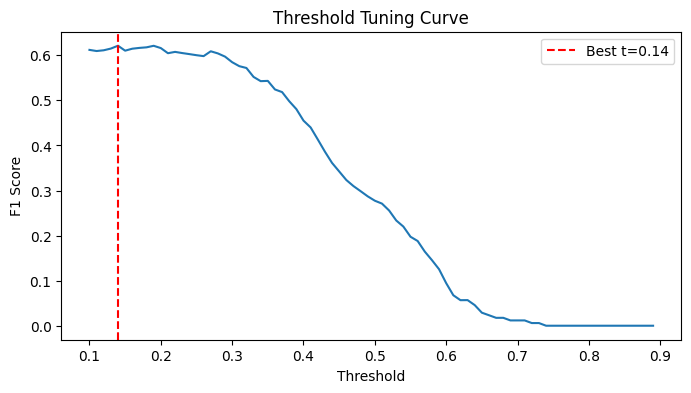


===== BiLSTM Evaluation =====
F1 @ threshold=0.5: 0.2774
Best threshold: 0.14
Best F1: 0.6213


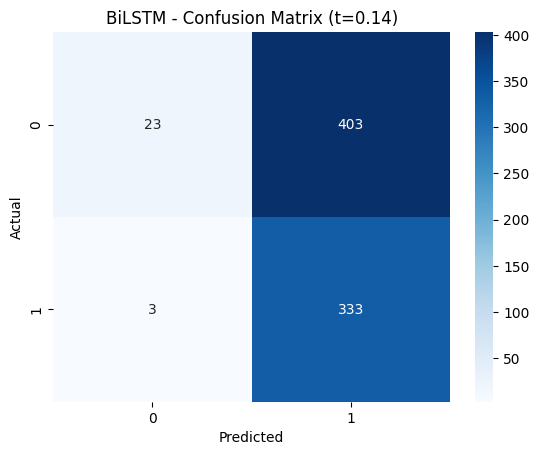

In [112]:
# Bi-directional LSTM model
model_bilstm = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

#Default learning rate 0.001
model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

history_bilstm = model_bilstm.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_bilstm, best_f1_bilstm = evaluate_model("BiLSTM", model_bilstm, X_val, y_val)

<h1>Result and Analysis</h1>

I have conducted several experiments:

Smaller LSTM units: Reducing the BiLSTM units to 32 achieved an F1 score: 0.6169, showing that smaller models can slightly reduce overfitting but did not drastically improve performance.

Trainable embeddings: Making the Word2Vec embeddings trainable, get the score: 0.6120, slightly lower, suggesting that trainable learning may not help in the case.

Adding dense layers and dropout: Introducing additional dense layers with dropout significantly improved performance, reaching an F1 score of 0.7480. This demonstrates that transforming features after the recurrent layer and applying regularization helps the model generalize better.

Learning rate tuning: Further adjusting the learning rate to 5e-4 on the dense-layer version boosted the F1 to 0.7618, showing that smaller learning rate also helps.

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.6889 - val_loss: 0.6842
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.6815 - val_loss: 0.6744
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.6673 - val_loss: 0.6697
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


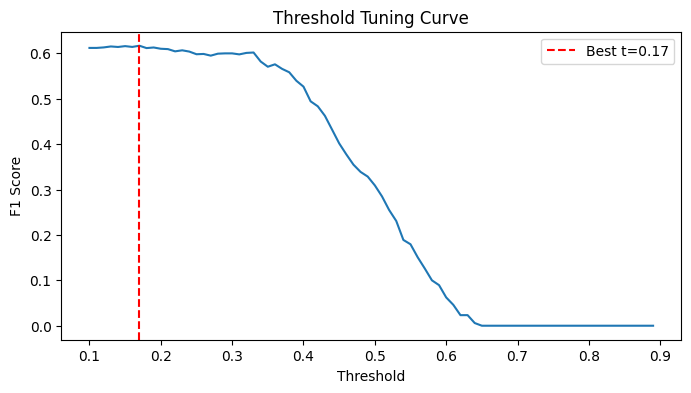


===== BiLSTM_32) Evaluation =====
F1 @ threshold=0.5: 0.3092
Best threshold: 0.17
Best F1: 0.6169


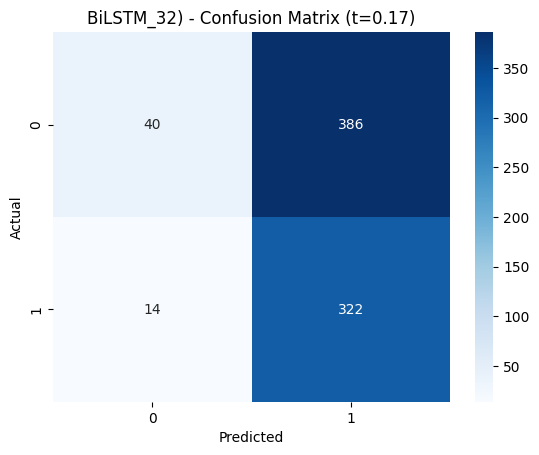

In [94]:
# Smaller unit2 Bi-LSTM , 64->32
model_bilstm_32 = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=False),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_bilstm_32.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

history_bilstm_32 = model_bilstm_32.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_bilstm_32, best_f1_bilstm_32 = evaluate_model("BiLSTM_32)", model_bilstm_32, X_val, y_val)

Epoch 1/3
  1/108 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.7313

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.6008 - val_loss: 0.5976
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.5944 - val_loss: 0.5990
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.5900 - val_loss: 0.5880
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


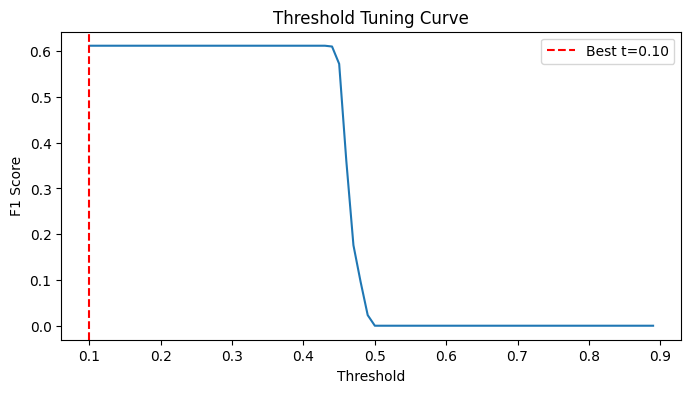


===== BiLSTM_trainable Evaluation =====
F1 @ threshold=0.5: 0.0000
Best threshold: 0.10
Best F1: 0.6120


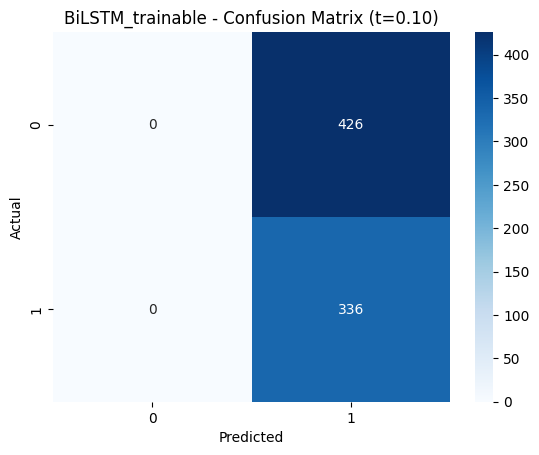

In [97]:
# Set the embedding layer as trainable so Word2Vec embeddings could adapt to the dataset
model_bilstm_trainable = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=True),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_bilstm_trainable.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

history_bilstm_trainable = model_bilstm.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_bilstm_trainable, best_f1_bilstm_trainable = evaluate_model("BiLSTM_trainable", model_bilstm_trainable, X_val, y_val)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 0.6881 - val_loss: 0.6757
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.5847 - val_loss: 0.4965
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.3158 - val_loss: 0.5361
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


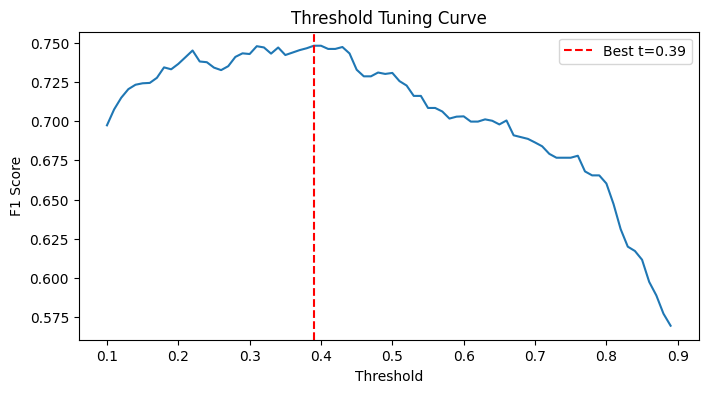


===== BiLSTM_Dense Evaluation =====
F1 @ threshold=0.5: 0.7306
Best threshold: 0.39
Best F1: 0.7480


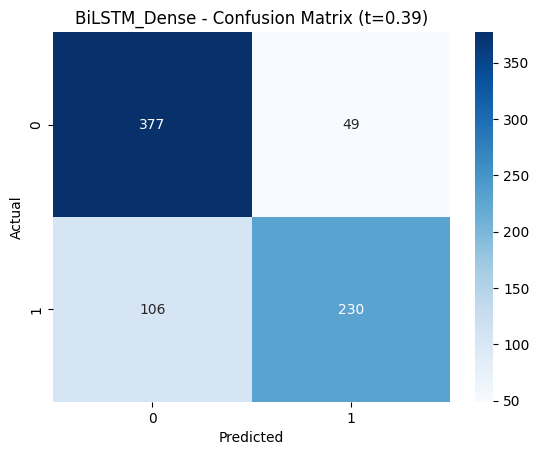

In [99]:
# Adding dense layers
model_dense = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_dense.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

history_dense = model_dense.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_dense, best_f1_dense = evaluate_model("BiLSTM_Dense", model_dense, X_val, y_val)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 0.6863 - val_loss: 0.6793
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.6396 - val_loss: 0.5433
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.4464 - val_loss: 0.4945
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


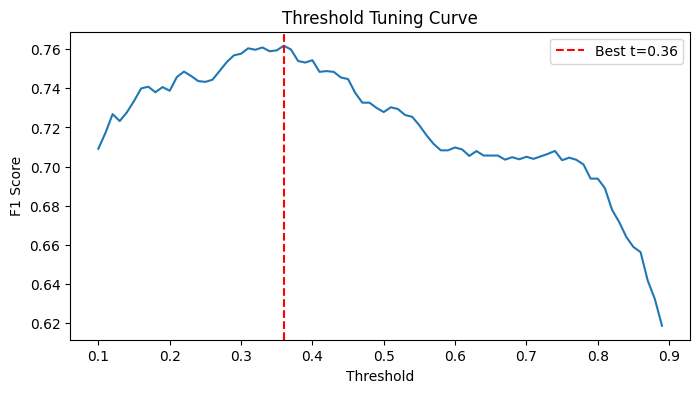


===== BiLSTM_lr Evaluation =====
F1 @ threshold=0.5: 0.7279
Best threshold: 0.36
Best F1: 0.7618


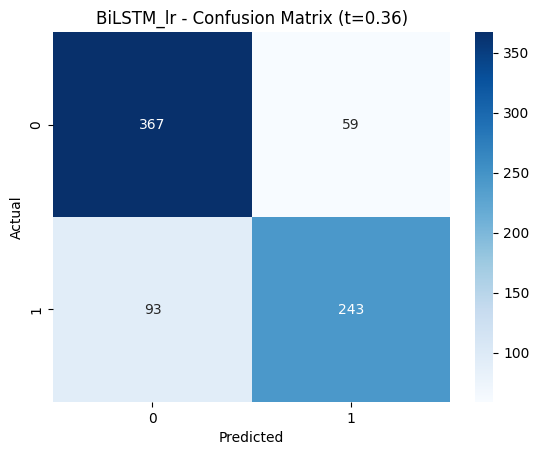

In [108]:
#Modifying learning rate
from tensorflow.keras.optimizers import Adam

model_lr = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              input_length=MAX_SEQ_LEN, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lr.compile(loss='binary_crossentropy',
                 optimizer=Adam(learning_rate=5e-4))

history_lr = model_lr.fit(
    X_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(X_val, y_val)
)

best_t_lr, best_f1_lr = evaluate_model("BiLSTM_lr", model_lr, X_val, y_val)


In [109]:
results_f1 = [
    ["LSTM", best_t_lstm, best_f1_lstm],
    ["BiLSTM", best_t_bilstm, best_f1_bilstm],
    ["BiLSTM_32", best_t_bilstm_32, best_f1_bilstm_32],
    ["BiLSTM_Dense", best_t_dense, best_f1_dense],
    ["BiLSTM_lr", best_t_lr, best_f1_lr],
    ["BiLSTM_trainable", best_t_bilstm_trainable, best_f1_bilstm_trainable]
    
]

results_f1_df = pd.DataFrame(results_f1, columns=["Model", "Best Threshold", "Best F1"])
results_f1_df.sort_values("Best F1", ascending=False)


,Model,Best Threshold,Best F1
4,BiLSTM_lr,0.36,0.761755
3,BiLSTM_Dense,0.39,0.747967
0,LSTM,0.32,0.617357
2,BiLSTM_32,0.17,0.616858
1,BiLSTM,0.18,0.616822
5,BiLSTM_trainable,0.10,0.612022


In [110]:
best_row = results_f1_df.sort_values("Best F1", ascending=False).iloc[0]
best_model_name = best_row["Model"]
best_t = best_row["Best Threshold"]

print("Best model:", best_model_name)
print("Best validation F1:", best_row["Best F1"])
print("Using threshold:", best_t)



Best model: BiLSTM_lr
Best validation F1: 0.7617554858934169
Using threshold: 0.3599999999999999


In [111]:
best_model = model_lr

y_test_prob = best_model.predict(X_test).ravel()
y_test_pred = (y_test_prob >= best_t).astype(int)

submission = pd.DataFrame({
    "id": test_df["id"],
    "target": y_test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


<h1>Conclusion</h1>
In this project, I explored various neural network architectures for disaster tweet classification using Word2Vec embeddings and sequential models. Starting with a basic LSTM model as a baseline.

Then I have experimented with more advanced architectures, including Bidirectional LSTM and BiLSTM with additional dense layers.

It is surprising that a simple basic LSTM provided a strong baseline with a decent F1 score.

The problem I was still confused about is that I thought bi-directional LSTM should perform better, but the actual F1 score is slightly lower. Because of the tweet, the past and future words should play important roles.

My guess is the tweets are too short, maybe the backward pass doesn't add much useful insight.

Furthermore, maybe we can try attention models or LLM to test if they can achieve better results.



<h1>Reference</h1>
KerasNLP starter notebook Disaster Tweets:  https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets/notebook

Word2Vec: https://www.tensorflow.org/text/tutorials/word2vec



<h1>Github Link</h1>
https://github.com/meng-shi/Natural-Language-Processing-with-Disaster-Tweets